### Get experiment data

In [2]:
from openff.evaluator import unit as openff_unit
from openff.evaluator.datasets import PhysicalProperty

In [3]:
targets_folder = "targets/host_guest_data"
energy_unit = openff_unit.kcal / openff_unit.mole

In [4]:
training_data = PhysicalProperty.from_json(f"{targets_folder}/training_set.json")

In [5]:
# Get experiment numerical value in kcal/mol
experiment = {
    "value": training_data.properties[0].value.to(energy_unit).magnitude,
    "uncertainty": training_data.properties[0].uncertainty.to(energy_unit).magnitude,
}
experiment

{'value': -2.280114722753346, 'uncertainty': 0.02987571701720841}

### Extract optimization data 

In [6]:
from glob import glob

from forcebalance.nifty import lp_load
from openff.toolkit.typing.engines.smirnoff import ForceField

try:
    import openmm.unit as openmm_unit
except ImportError:
    import simtk.unit as openmm_unit

In [7]:
optimize_folder = "optimize.tmp/host_guest_data"
ff_filename = "openff-2.0.0-GBSA_OBC1-tagged.offxml"
n_iterations = len(glob(f"{optimize_folder}/iter*"))

In [8]:
calculation = {"value": [], "uncertainty": []}
atom_type = "[#8:1]"
GB_radius = {atom_type: []}
objective_function = []

In [9]:
for iteration in range(n_iterations):
    folder_name = f"{optimize_folder}/iter_{iteration:04}"

    # Collect objective function
    file_path = f"{folder_name}/objective.p"
    statistics = lp_load(file_path)
    objective_function.append(statistics["X"])

    # Load Evaluator results for current iteration
    with open(f"{folder_name}/results.json", "r") as f:
        data = json.load(f)

    # Get the single property
    hg_property = data["estimated_properties"]["properties"][0]

    # Store dG value and uncertainty and get numerical value in kcal/mol
    calculation["value"].append(
        openff_unit.Quantity(
            hg_property["value"]["value"],
            units=hg_property["value"]["unit"],
        )
        .to(energy_unit)
        .magnitude
    )
    calculation["uncertainty"].append(
        openff_unit.Quantity(
            hg_property["uncertainty"]["value"],
            units=hg_property["uncertainty"]["unit"],
        )
        .to(energy_unit)
        .magnitude
    )

    # Get the GB radius value in Angstrom
    ff = ForceField(f"{folder_name}/{ff_filename}", allow_cosmetic_attributes=True)

    GB_radius[atom_type].append(
        ff.get_parameter_handler("GBSA")[atom_type].radius.value_in_unit(
            openmm_unit.angstrom
        )
    )

### Evolution of objective function

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

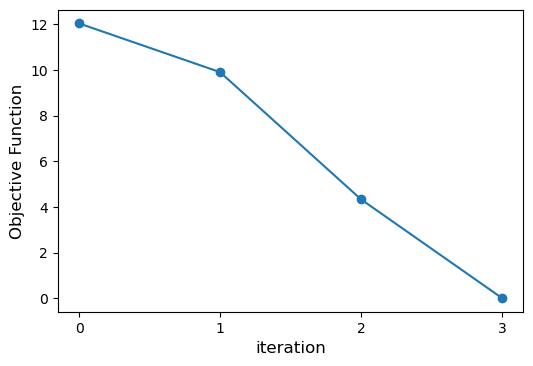

In [11]:
ax = plt.figure(dpi=100).gca()
plt.plot(range(n_iterations), objective_function, marker="o")
plt.xlabel("iteration", fontsize=12)
plt.ylabel("Objective Function", fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig("objective_function.png", dpi=100, bbox_inches="tight")

### Evolution of $\Delta$G

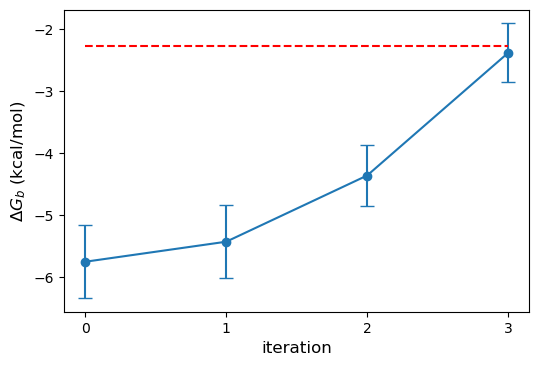

In [12]:
ax = plt.figure(dpi=100).gca()
plt.errorbar(
    range(n_iterations),
    y=calculation["value"],
    yerr=calculation["uncertainty"],
    marker="o",
    capsize=5,
)

plt.plot([0, n_iterations-1], [experiment["value"], experiment["value"]], "--r")

plt.xlabel("iteration", fontsize=12)
plt.ylabel(r"$\Delta G_{b}$ (kcal/mol)", fontsize=12)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig("free_energy.png", dpi=100, bbox_inches="tight")

### Evolution of GB radius

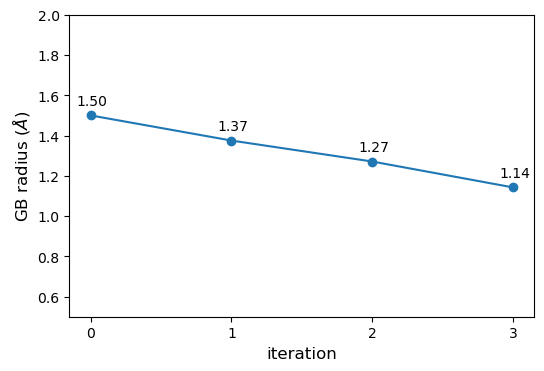

In [13]:
ax = plt.figure(dpi=100).gca()

x = range(n_iterations)
y = GB_radius[atom_type]

plt.plot(x, y, marker="o")
plt.xlabel("iteration", fontsize=12)
plt.ylabel(r"GB radius ($\AA$)", fontsize=12)
plt.ylim(0.5, 2)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for i in range(n_iterations):
    plt.annotate(f"{GB_radius[atom_type][i]:.2f}", (x[i]-0.1, y[i] + 0.05))
    
plt.savefig("GB_radius.png", dpi=100, bbox_inches="tight")